In [9]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

fight_data_file = '../ufcdata/data.csv'
fight_data_file_prep = '../ufcdata/preprocessed_data.csv'
scorecard_data_file = '../ufcdata/scorecard.csv'
hometown_data_file = '../elevations/fighters_elevation.csv'

def import_and_merge():
    fight_data = pd.read_csv(fight_data_file)
    hometown_data = pd.read_csv(hometown_data_file)
    
    #Add Blue and Red win columns
    fight_data['B_Winner'] = [1 if x=='Blue' else 0 for x in fight_data['Winner']]
    fight_data['R_Winner'] = [1 if x=='Red' else 0 for x in fight_data['Winner']]
    
    #Drop columns irrelevant to this prediction
    fight_data = fight_data.drop(columns=['Referee', 'no_of_rounds', 'Winner', 'date', 'R_Stance', 'B_Stance'])
    print('Fight Data Stats: ')
    print('Shape: ', fight_data.shape)
    #display(fight_data)
    
    #Separate fight data into individual fighter stats
    blue_fighters = fight_data.loc[:, [col for col in fight_data.columns if re.search('^R_', col)==None]]
    blue_fighters = blue_fighters.rename(columns=lambda x: re.sub('^B_', '', x))
    print('\nBlue fighter Stats: ')
    print('Shape: ', blue_fighters.shape)
    #display(blue_fighters)
    
    red_fighters = fight_data.loc[:, [col for col in fight_data.columns if re.search('^B_', col)==None]]
    red_fighters = red_fighters.rename(columns=lambda x: re.sub('^R_', '', x))
    print('\nRed fighter Stats: ')
    print('Shape: ', red_fighters.shape)
    #display(red_fighters)
    
    #Concatenate blue and red fighter stats
    fighters_data = pd.concat([blue_fighters, red_fighters])
    fighters_data = fighters_data.rename(columns={'total_time_fought(seconds)':'total_time_fought_seconds'})
    print('\nTotal fighter Stats: ')
    print('Shape: ', fighters_data.shape)
    
    # Create df without offence stats
    fighters_no_offence_stats = fighters_data.drop(columns=[col for col in fighters_data.columns if re.search(r'^avg_', col) != None])
    fighters_no_offence_stats = fighters_no_offence_stats.drop(columns='total_time_fought_seconds')
    
    #Merge with home town data
    hometown_data['merge_key'] = hometown_data['Fighter Name'].apply(lambda x: ' '.join(sorted(str.lower(x).split())))
    hometown_data = hometown_data[~hometown_data.duplicated('merge_key', keep='first')]
    print('\nHometown Stats: ')
    print('Shape: ', hometown_data.shape)
    
    merged_df = fighters_data.copy()
    merged_df['merge_key'] = merged_df['fighter'].apply(lambda x: ' '.join(sorted(str.lower(x).split())))
    merged_df = pd.merge(left=merged_df, right=hometown_data, how='left', left_on='merge_key', right_on='merge_key')
    merged_df = merged_df.drop(columns=['Fighter Name', 'merge_key'])
    merged_df = merged_df.rename(columns={'Location':'hometown'})
    print('\nMerged DF Stats: ')
    print('Shape: ', merged_df.shape)
    #display(merged_df)

    
    return (fighters_no_offence_stats, fighters_data, merged_df)
    

data_no_offence_stats, data, data_w_hometown,  = import_and_merge()

Fight Data Stats: 
Shape:  (5144, 141)

Blue fighter Stats: 
Shape:  (5144, 72)

Red fighter Stats: 
Shape:  (5144, 72)

Total fighter Stats: 
Shape:  (10288, 72)

Hometown Stats: 
Shape:  (1331, 4)

Merged DF Stats: 
Shape:  (10288, 74)


<Figure size 2160x936 with 0 Axes>

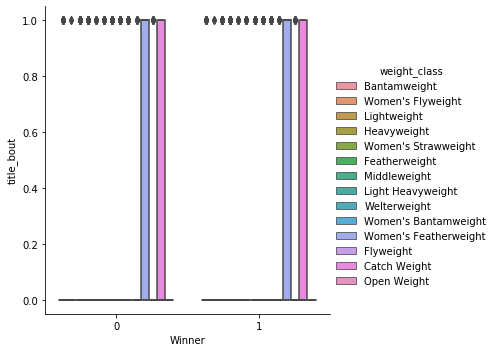

<Figure size 2160x936 with 0 Axes>

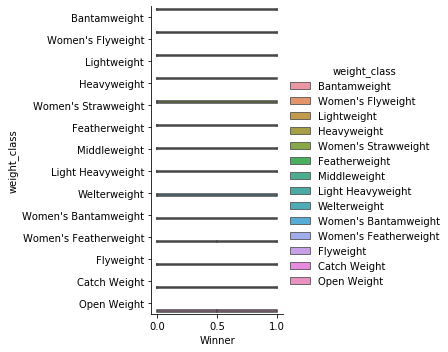

<Figure size 2160x936 with 0 Axes>

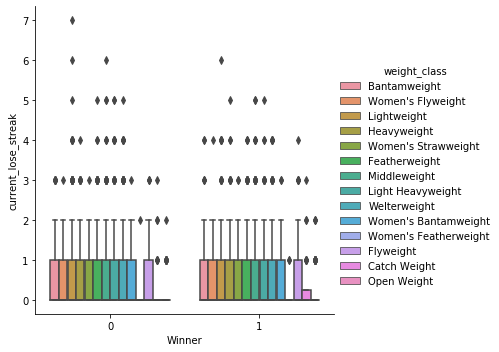

<Figure size 2160x936 with 0 Axes>

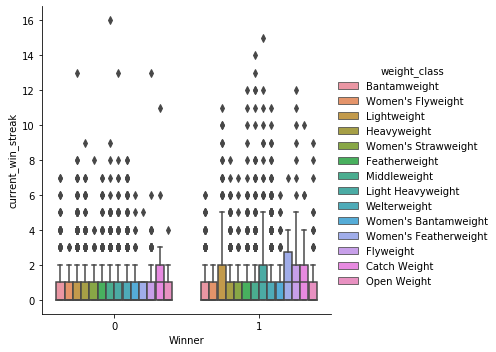

<Figure size 2160x936 with 0 Axes>

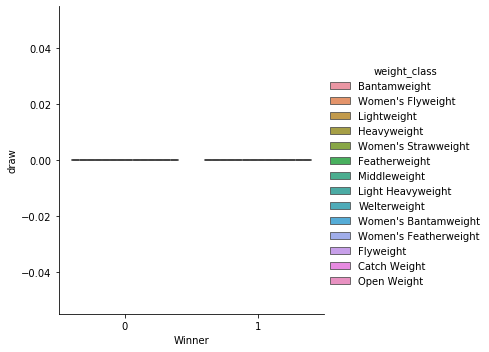

<Figure size 2160x936 with 0 Axes>

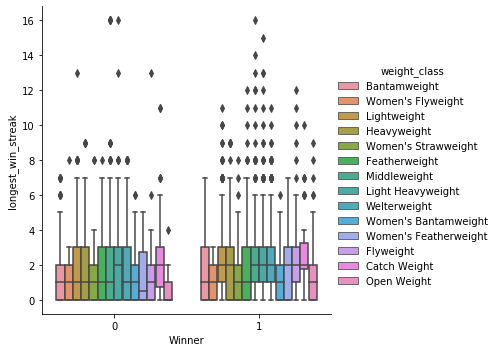

<Figure size 2160x936 with 0 Axes>

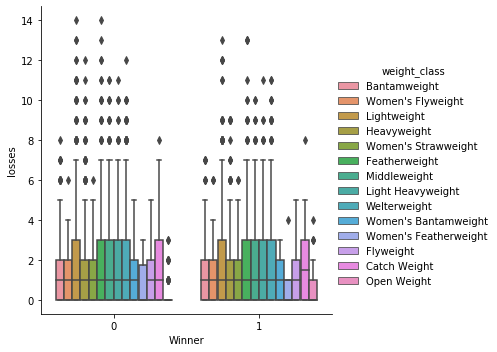

<Figure size 2160x936 with 0 Axes>

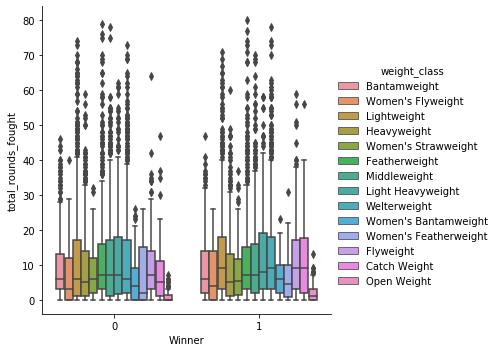

<Figure size 2160x936 with 0 Axes>

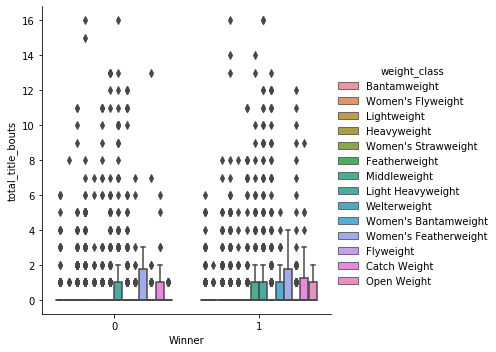

<Figure size 2160x936 with 0 Axes>

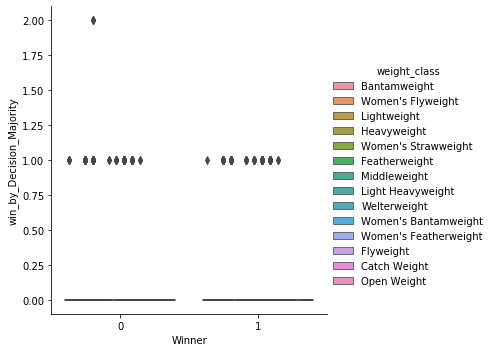

<Figure size 2160x936 with 0 Axes>

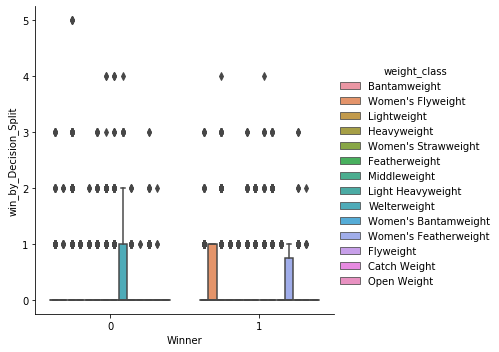

<Figure size 2160x936 with 0 Axes>

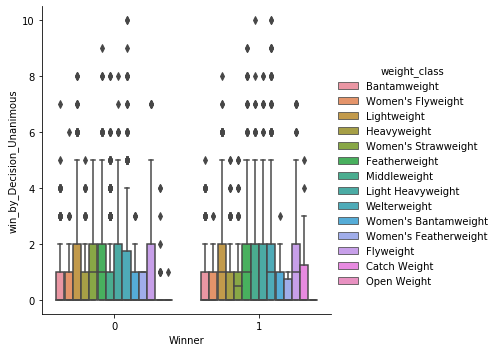

<Figure size 2160x936 with 0 Axes>

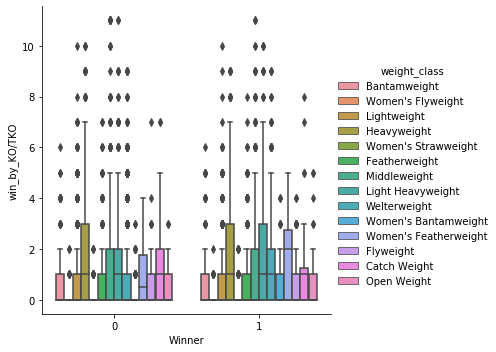

<Figure size 2160x936 with 0 Axes>

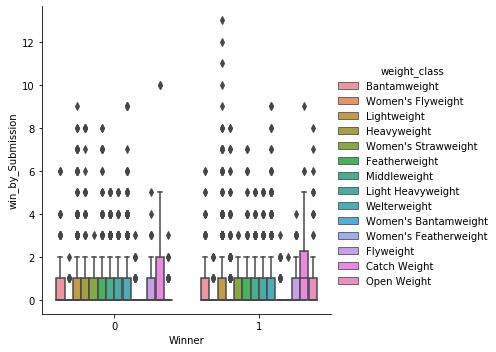

<Figure size 2160x936 with 0 Axes>

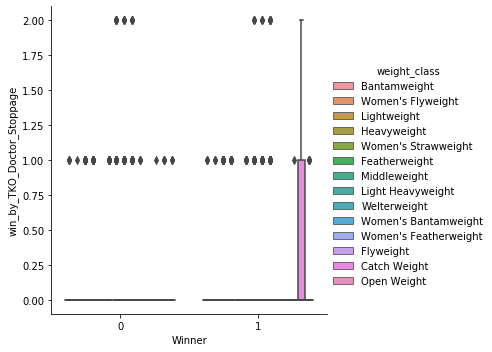

<Figure size 2160x936 with 0 Axes>

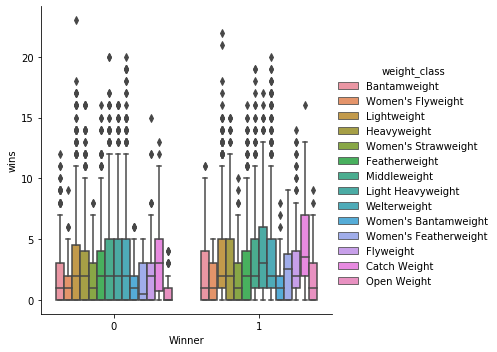

<Figure size 2160x936 with 0 Axes>

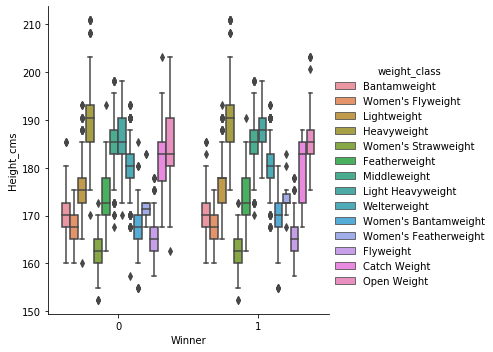

<Figure size 2160x936 with 0 Axes>

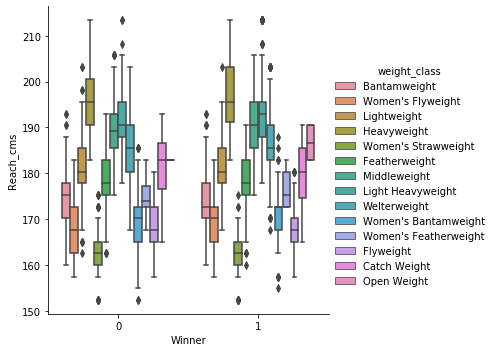

<Figure size 2160x936 with 0 Axes>

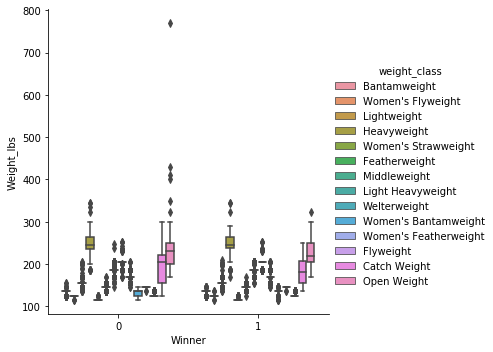

<Figure size 2160x936 with 0 Axes>

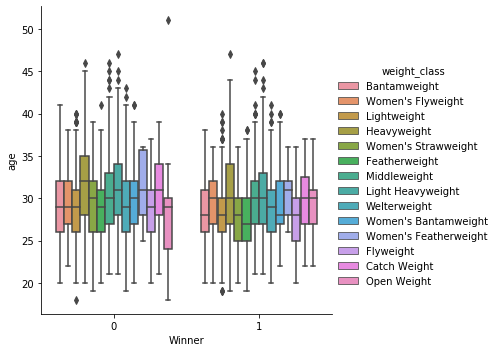

<Figure size 2160x936 with 0 Axes>

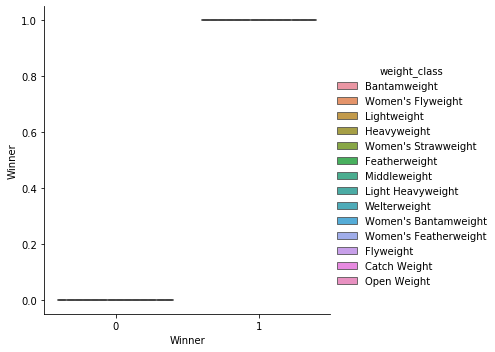

<Figure size 2160x936 with 0 Axes>

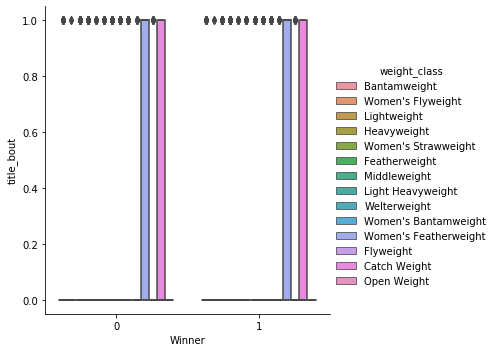

<Figure size 2160x936 with 0 Axes>

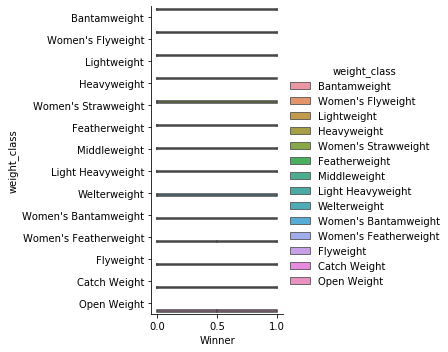

<Figure size 2160x936 with 0 Axes>

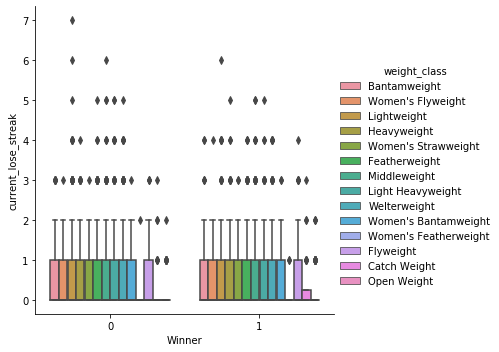

<Figure size 2160x936 with 0 Axes>

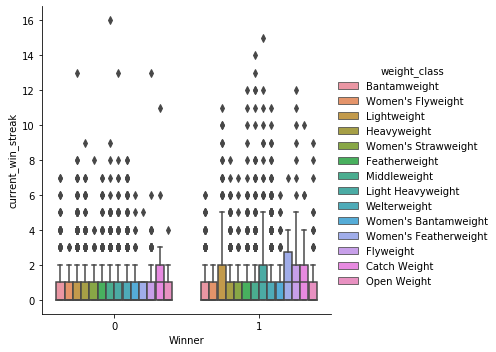

<Figure size 2160x936 with 0 Axes>

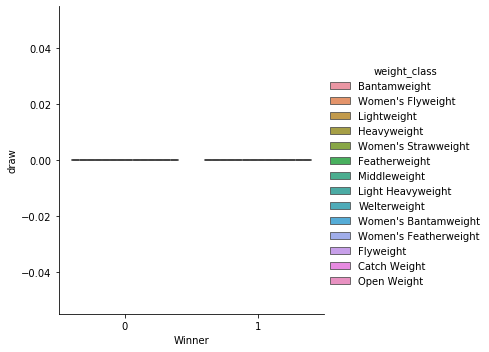

<Figure size 2160x936 with 0 Axes>

<Figure size 2160x936 with 0 Axes>

<Figure size 2160x936 with 0 Axes>

<Figure size 2160x936 with 0 Axes>

<Figure size 2160x936 with 0 Axes>

<Figure size 2160x936 with 0 Axes>

<Figure size 2160x936 with 0 Axes>

<Figure size 2160x936 with 0 Axes>

<Figure size 2160x936 with 0 Axes>

<Figure size 2160x936 with 0 Axes>

<Figure size 2160x936 with 0 Axes>

<Figure size 2160x936 with 0 Axes>

<Figure size 2160x936 with 0 Axes>

<Figure size 2160x936 with 0 Axes>

<Figure size 2160x936 with 0 Axes>

<Figure size 2160x936 with 0 Axes>

<Figure size 2160x936 with 0 Axes>

<Figure size 2160x936 with 0 Axes>

<Figure size 2160x936 with 0 Axes>

<Figure size 2160x936 with 0 Axes>

<Figure size 2160x936 with 0 Axes>

<Figure size 2160x936 with 0 Axes>

<Figure size 2160x936 with 0 Axes>

<Figure size 2160x936 with 0 Axes>

<Figure size 2160x936 with 0 Axes>

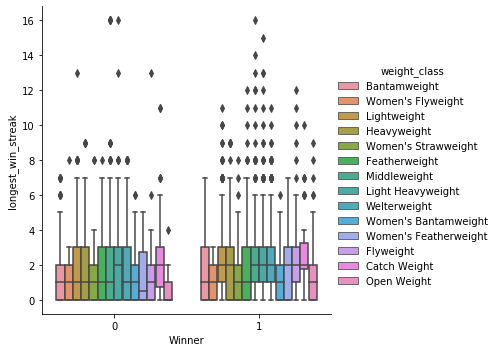

<Figure size 2160x936 with 0 Axes>

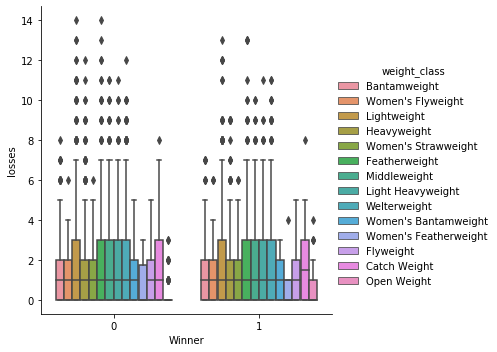

<Figure size 2160x936 with 0 Axes>

<Figure size 2160x936 with 0 Axes>

<Figure size 2160x936 with 0 Axes>

<Figure size 2160x936 with 0 Axes>

<Figure size 2160x936 with 0 Axes>

<Figure size 2160x936 with 0 Axes>

<Figure size 2160x936 with 0 Axes>

<Figure size 2160x936 with 0 Axes>

<Figure size 2160x936 with 0 Axes>

<Figure size 2160x936 with 0 Axes>

<Figure size 2160x936 with 0 Axes>

<Figure size 2160x936 with 0 Axes>

<Figure size 2160x936 with 0 Axes>

<Figure size 2160x936 with 0 Axes>

<Figure size 2160x936 with 0 Axes>

<Figure size 2160x936 with 0 Axes>

<Figure size 2160x936 with 0 Axes>

<Figure size 2160x936 with 0 Axes>

<Figure size 2160x936 with 0 Axes>

<Figure size 2160x936 with 0 Axes>

<Figure size 2160x936 with 0 Axes>

<Figure size 2160x936 with 0 Axes>

<Figure size 2160x936 with 0 Axes>

<Figure size 2160x936 with 0 Axes>

<Figure size 2160x936 with 0 Axes>

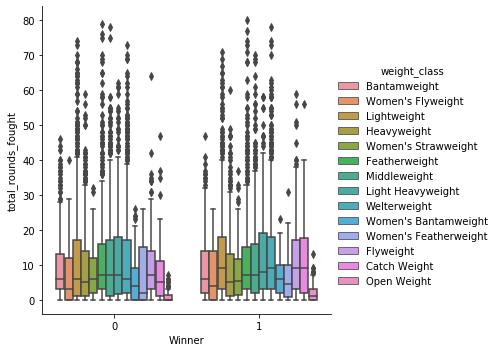

<Figure size 2160x936 with 0 Axes>

<Figure size 2160x936 with 0 Axes>

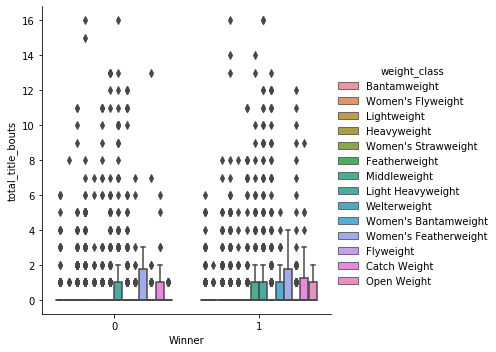

<Figure size 2160x936 with 0 Axes>

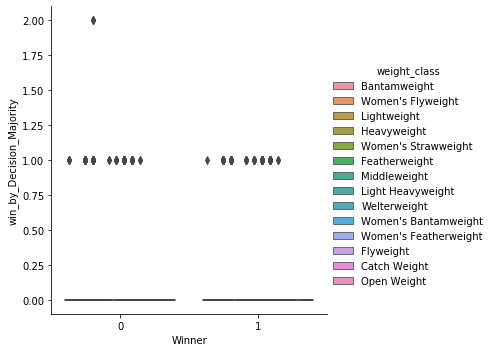

<Figure size 2160x936 with 0 Axes>

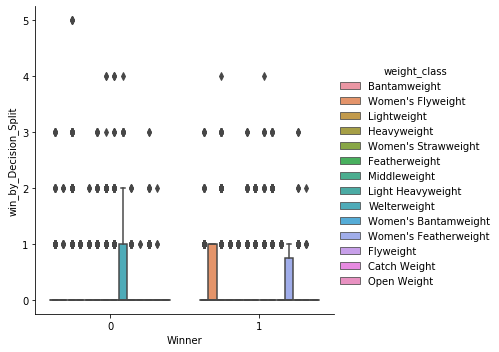

<Figure size 2160x936 with 0 Axes>

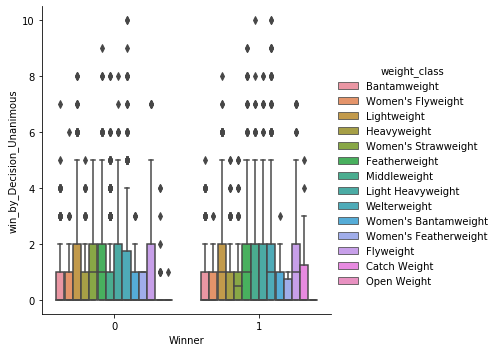

<Figure size 2160x936 with 0 Axes>

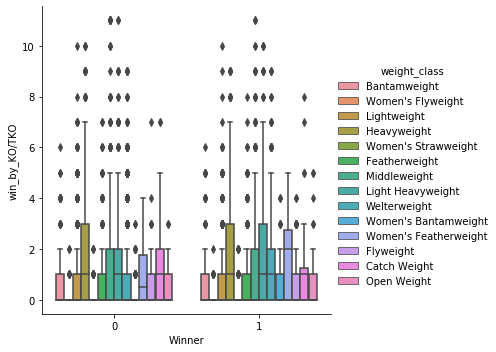

<Figure size 2160x936 with 0 Axes>

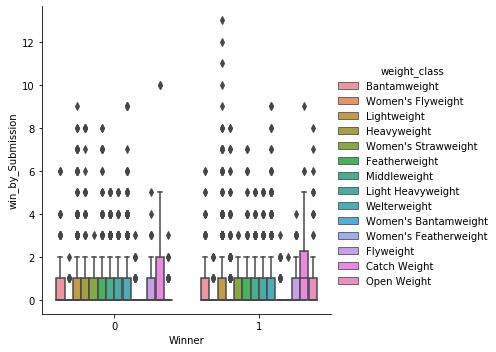

<Figure size 2160x936 with 0 Axes>

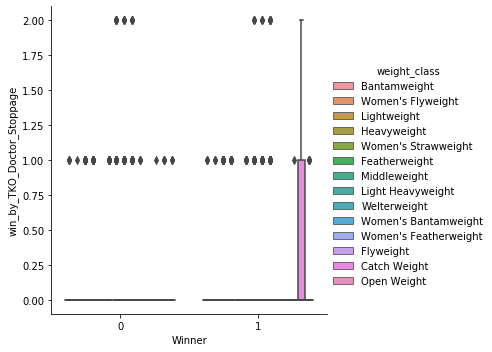

<Figure size 2160x936 with 0 Axes>

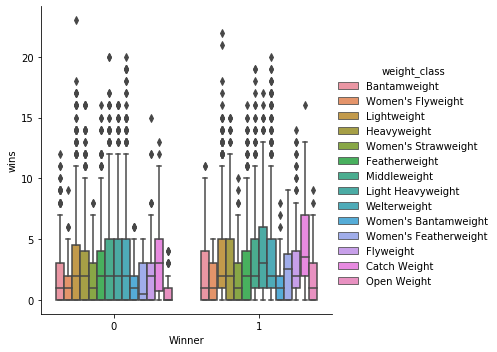

<Figure size 2160x936 with 0 Axes>

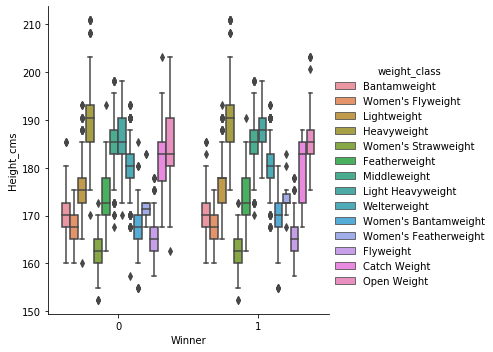

<Figure size 2160x936 with 0 Axes>

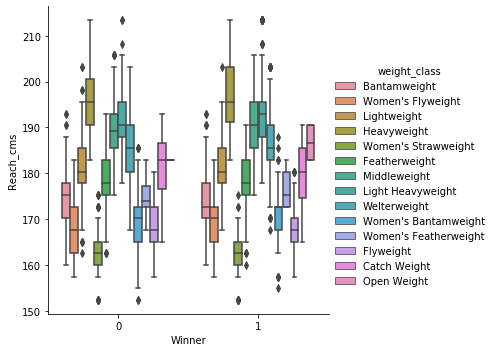

<Figure size 2160x936 with 0 Axes>

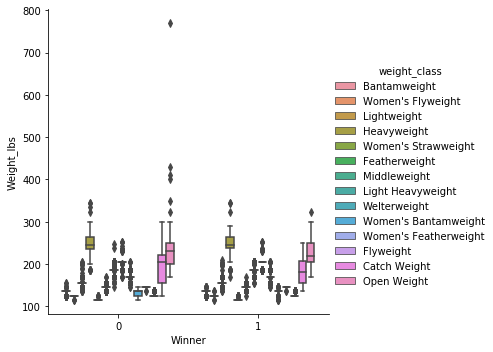

<Figure size 2160x936 with 0 Axes>

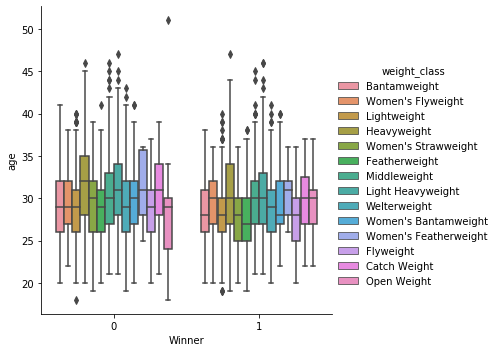

<Figure size 2160x936 with 0 Axes>

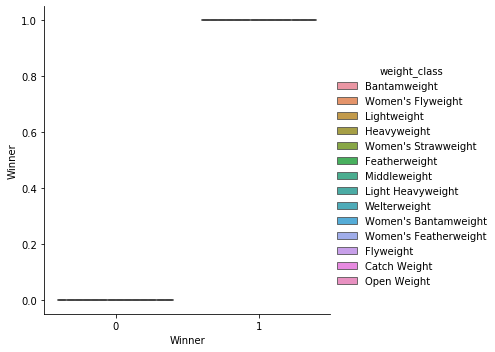

In [26]:
import seaborn as sns


for column in data_no_offence_stats.drop(columns=['fighter', 'location']).columns:
    try:
        fig = plt.figure(figsize=(30, 13))
        sns.catplot(x='Winner', y=column, data=data_no_offence_stats, kind='box', hue='weight_class');
        plt.show()
    except:
        pass

for column in data.drop(columns=['fighter', 'location']).columns:  
    try:
        fig = plt.figure(figsize=(30, 13))
        sns.catplot(x='Winner', y=column, data=data_no_offence_stats, kind='box', hue='weight_class');
        plt.show()
    except:
        pass
# a = data_no_offence_stats.drop(columns=['location', 'fighter', 'weight_class']).corr()['Winner'][:]
# a = a.drop(['Winner']) * 100
# fig = plt.figure(figsize=(30, 13))
# ax = plt.axes()
# ax.bar(data_no_offence_stats.drop(columns=['location', 'fighter', 'weight_class', 'Winner']).columns, abs(a))
# plt.xticks(rotation='vertical')
# plt.ylabel('Correlation')

# a = data.drop(columns=['location', 'fighter', 'weight_class']).corr()['Winner'][:]
# a = a.drop(['Winner']) * 100
# fig = plt.figure(figsize=(30, 13))
# ax = plt.axes()
# ax.bar(data.drop(columns=['location', 'fighter', 'weight_class', 'Winner']).columns, abs(a))
# plt.xticks(rotation='vertical')
# plt.ylabel('Correlation')

In [ ]:
# Tuned Parameters for unsclaed data. Data with no offensive stats
knn_params =  {'algorithm': 'auto', 'n_neighbors': 19}
lr_params = {'C': 0.001, 'solver': 'newton-cg'}
svc_params = {'C': 0.11326530614693876}
nbayes_params =  {'alpha': 12.428571428612246}
rforest_params = {'max_depth': 7.5102040816326525, 'max_features': 'auto', 'min_samples_split': 4}
df = structure_data(data_no_offence_stats.copy())
df = clean_data(df)
df = df.drop(columns=['fighter'])
dummy_df = pd.get_dummies(df)

labels = dummy_df['Winner']
features = dummy_df.drop(columns=['Winner'])
compare_models(knn_params, lr_params, svc_params, nbayes_params, rforest_params, features, labels)